# World Cup Data Exploration using SparkSQL

***

![FIFA World Cup](https://images.unsplash.com/photo-1518091043644-c1d4457512c6?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1931&q=80)

Credit: Photo by <a href="https://unsplash.com/it/@fznsr_?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Fauzan Saari</a> on <a href="https://unsplash.com/photos/cjYQBSKDSII?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

**Dataset Source:** 

martj42's GitHub repository ([link](https://github.com/martj42/international_results))

**Description:**

The CSV file stores a dataset of international football match results, from the first officially recorded match dated back in 1872 to the most recent matches in Qatar (as of 18 November 2022). The data, however, only records full men’s international matches, excluding Olympic Games, B-team league and U-23 league.

The dataset contains *44,066 records* of the matches and *9 columns* containing the following attributes:

* Date – the date of the match
* Home_team – the country name of the home team
* Away_team – the country name of the away team
* Home_score – the home team score, including extra time
* Away_score – the away team score, including extra time
* Tournament – the name or type of tournament being held
* City – the city where the match was held
* Country – the country where the match was held
* Neutral – a boolean attribute to indicate whether the match was held in a neutral venue i.e. not favouring the home team

**Objectives:**

Perform exploratory data analysis on the dataset to get insights into the football scene by using SparkSQL.

Some questions that we are looking for are:

* How many FIFA matches have been held so far?
* Which teams qualified, hence participated the most in FIFA?
* Which teams are the top performing teams?
* How has international football scene develop over the years?

## I. Import relevant libraries

We will be using Spark to perform our queries and EDA. Although Spark is mainly built to perform analysis on big data, we will utilise this to execute SQL queries and display its integration capability with pandas API.

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

## II. Create SparkSession

We start by creating a SparkSession, which we will use to create the dataframe. We read the `worldcup.csv` file using the `.csv()` on top of custom configuration `.option()`. The `inferSchema` option allows Spark to infer the data types for each column and `header` option tells Spark that the CSV file has column headers on the first row.

In [2]:
spark = (SparkSession.builder
             .config("spark.driver.memory","4g")
             .config("spark.driver.maxResultSize", "4g")
             .getOrCreate())

In [10]:
df = spark.read.option("inferSchema", True) \
               .option("header", True) \
               .csv("worldcup.csv")

df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_score: string (nullable = true)
 |-- away_score: string (nullable = true)
 |-- tournament: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- neutral: boolean (nullable = true)



We change the schema type for "date" column from timestamp to date.

In [25]:
# Change schema type of date to datetype 
df = df.withColumn("date", f.col("date").cast(t.DateType()))
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_score: string (nullable = true)
 |-- away_score: string (nullable = true)
 |-- tournament: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- neutral: boolean (nullable = true)



## III. Create temporary view table

To perform the analysis using SparkSQL queries, we first need to create a "temporary view" table, which literally creates read-only temporary SQL table.

In [26]:
df.createOrReplaceTempView("matches")

## IV. Exploratory Data Analysis using SparkSQL

In [27]:
def run(query):
    # Run SparkSQL query and return a pandas dataframe
    return spark.sql(query).toPandas()

### 1. Basic Explorations

#### 1.1. View the top 5 from the dataframe.

To start off, we view the top 5 rows of the dataset and get a sense of how the dataset looks. There are 9 columns, with date of the football match, home and away teams, tournament type and location.

In [32]:
query = """
SELECT *
FROM matches
LIMIT 5;
"""

run(query)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


#### 1.2. Brief overview of the overall football scene

From the output, we understand that the first international football match was held in 1872. Up to this date, there are 139 unique tournaments recorded with 267 participating countries. The dataframe contains 44,152 rows, with 311 and 306 distinct home and away teams respectively. Out of the 44,152 matches held to date, there are about a quarter of them held in neutral venues.

In [34]:
query = """
SELECT MIN(EXTRACT(YEAR FROM date)) AS start_year
    , COUNT(DISTINCT(home_team)) AS home
    , COUNT(DISTINCT(away_team)) AS away
    , COUNT(DISTINCT tournament) AS nunique_tournament
    , COUNT(DISTINCT country) AS nunique_country
    , COUNT(*) AS num_matches
    , COUNT(*) FILTER(WHERE neutral = TRUE) AS neutral_venues
FROM matches;
"""

run(query)
run(query)

,count,home,away,tourney,country
0,44152,311,306,139,267


#### 1.3. View the basic statistics of the home and away scores

The home team, on average, seems to score slightly higher than the away team with the mean scores being 1.74 and 1.17 respectively. Meanwhile, the standard deviation is at 1.75 and 1.39 respectively.

In [60]:
query = """
SELECT "home" AS team
    , AVG(home_score) AS mean
    , STD(home_score) AS stdev
    , CAST(PERCENTILE(home_score, 0.95) AS INT) AS q95
    , cAST(PERCENTILE(home_score, 1) AS INT) AS top_score
FROM matches

UNION ALL

SELECT "away" AS team
    , AVG(away_score) AS mean
    , STD(away_score) AS stdev
    , CAST(PERCENTILE(away_score, 0.95) AS INT) AS q95
    , CAST(PERCENTILE(away_score, 1) AS INT) AS top_score
FROM matches;
"""

run(query)

,team,mean,stdev,q95,top_score
0,home,1.740046,1.747194,5,31
1,away,1.178147,1.394705,4,21


#### Hypothesis testing: Home v.s. Away

We can check if home team trully has an advantage over the away team by doing hypothesis testing on the scores.

$$H_0: \mu_{home} = \mu_{away}$$
$$H_1: \mu_{home} > \mu_{away}$$

Since the sample size is large (44k), we will use Z-score test and reject the null hypothesis at 5% significance level when Z-score > 1.645 (right-tailed test). 

The Z-score can be calculated as:

$$Z = \frac{\mu_{home} - \mu_{away}}{\sigma_{home}}$$

In [63]:
home_mean = 1.740046
away_mean = 1.178147
home_stdev = 1.747194

z_score = (home_mean - away_mean) / home_stdev
print(f"Z-score: {z_score:.3f}")

Z-score: 0.322


Since the Z-score is much lower than the critical value at 1.645, we cannot reject the null hypothesis that there is no statistically significant difference between home and away scores. 

Therefore, we can conclude that the home team, in fact, does not have any advantages against the away team.

### 2. Most frequently held tournaments

To query for the most frequently held matches, we group by the "tournament" column and count the number of rows. Using `MIN/MAX`-`EXTRACT`-`YEAR`, we can also tell when the tourney first started and last held. We specify `LIMIT` to 25 after using `ORDER DESC` to get the top 25 matches.

Not surprisingly, the most frequently held matches are friendly matches totalling to 17.5k matches which makes up about 39.5% of all men's football matches. FIFA world cup, EUFA Euro and African Cup qualifiers are the next three highest totalling to 7.7k (17.6%), 2.6k (5.9%) and 1.9k (4.4%) matches.

In [65]:
query = """
SELECT tournament
    , MIN(EXTRACT(YEAR FROM date)) AS start_year
    , MAX(EXTRACT(YEAR FROM date)) AS latest_year
    , COUNT(DISTINCT EXTRACT(YEAR FROM date)) AS num_years
    , COUNT(*) AS num_matches
    , ROUND(1.0 * COUNT(*) / (SELECT COUNT(*) FROM matches), 3) AS propn_matches
FROM matches
GROUP BY tournament
ORDER BY num_matches DESC
LIMIT 25;
"""

df_vis1 = run(query)
df_vis1.head()

,tournament,start_year,latest_year,num_years,num_matches,propn_matches
0,Friendly,1872,2022,136,17461,0.395
1,FIFA World Cup qualification,1933,2022,52,7774,0.176
2,UEFA Euro qualification,1958,2020,38,2593,0.059
3,African Cup of Nations qualification,1961,2022,53,1932,0.044
4,FIFA World Cup,1930,2022,22,948,0.021


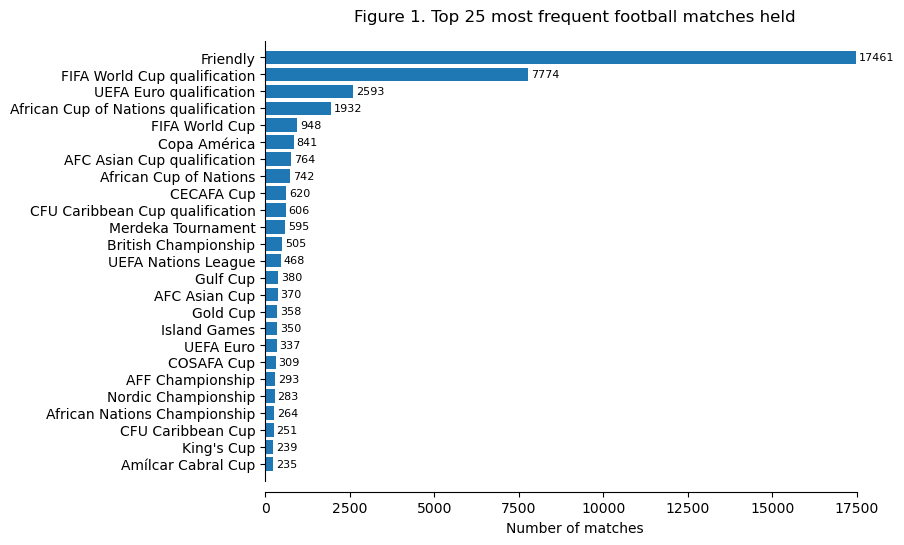

In [136]:
fig, ax = plt.subplots(figsize=(8,6))
rect = ax.barh(y=df_vis1["tournament"], width=df_vis1["num_matches"])
ax.bar_label(rect, padding=2, fmt="%i", size=8)
ax.invert_yaxis()
ax.spines['right'].set(visible=False)
ax.spines['top'].set(visible=False)
ax.spines['left'].set_bounds(-1,25)
ax.spines['bottom'].set_bounds(0,17500)
plt.title("Figure 1. Top 25 most frequent football matches held")
plt.xlabel("Number of matches")
plt.show()

### 3. Top performers in FIFA World Cup

Here, we define top performing by looking at the number of matches won by each team in the FIFA tournament. We specify that the team needs to win at least more than 10 matches. To ensure that we only account for official FIFA world cup matches, we exclude tournaments that contains the world "qualification" and "anniversary". Using `CASE WHEN` statement to draw the winning team by comparing the score between home and away team.

As we can see from the output result, Brazil seems to have the highest win count of 73 with greater than 2-goal difference on average, followed by Germany. It is interesting to observe that the 15th team in terms of number of winning matches has a very high score difference of 3.8 when they win.

In [143]:
query = """
SELECT CASE WHEN home_score > away_score THEN home_team
            WHEN away_score > home_score THEN away_team
            ELSE 'draw' END AS winner
    , COUNT(*) AS num_matches_won
    , ROUND(AVG(ABS(home_score - away_score)), 2) AS avg_score_diff
FROM matches
WHERE tournament ILIKE '%fifa%'
AND NOT LOWER(tournament) LIKE '%(qualification|anniversary)%'
AND home_score <> away_score
GROUP BY 1
HAVING COUNT(*) > 10
ORDER BY 2 DESC;
"""

df_vis2 = run(query)
print(df_vis2.shape)
df_vis2.head(10)

(142, 3)


,winner,num_matches_won,avg_score_diff
0,Brazil,155,2.45
1,Germany,150,2.67
2,Argentina,129,1.98
3,Italy,123,2.05
4,Spain,117,2.41
5,Netherlands,116,2.67
6,Mexico,114,2.66
7,England,113,2.74
8,Sweden,105,2.30
9,France,104,2.36


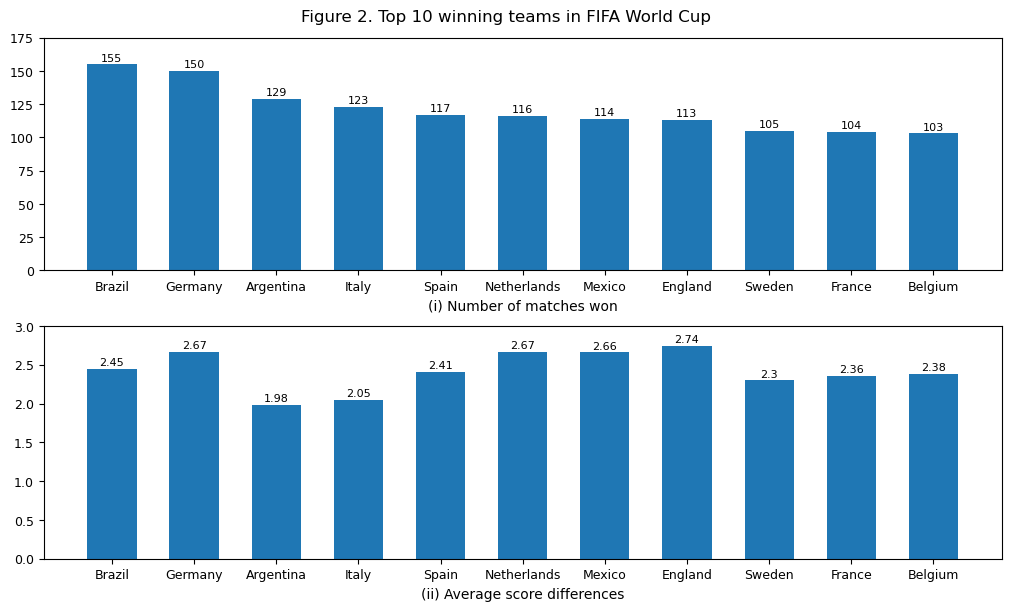

In [197]:
fig, axes = plt.subplots(nrows=2, layout="constrained", figsize=(10,6))

rect1 = axes[0].bar(x=df_vis2.loc[:10,"winner"], height=df_vis2.loc[:10,"num_matches_won"], width=0.6)
axes[0].bar_label(rect1, padding=1, size=8)
axes[0].tick_params(axis="both", labelsize=9)
axes[0].set_yticks(np.arange(0,200,25))
axes[0].set_xlabel("(i) Number of matches won")

rect2 = axes[1].bar(x=df_vis2.loc[:10,"winner"], height=df_vis2.loc[:10,"avg_score_diff"], width=0.6)
axes[1].bar_label(rect2, padding=1, size=8, fmt="%.2f")
axes[1].tick_params(axis="both", labelsize=9)
axes[1].set_yticks(np.arange(0,3.5,0.5))
axes[1].set_xlabel("(ii) Average score differences")

plt.suptitle("Figure 2. Top 10 winning teams in FIFA World Cup")
plt.show()

### 4. Top 10 most frequent FIFA participants and their performances

To calculate the frequency of the team’s participation, we should not make distinction between home and away team. Hence, we combine the home_team and away_team columns into a single column "team", and we will do the same to the home_score and away_score columns into column "score". To do this, we can use CTEs to perform two subqueries, one on home teams and the other on away teams. These two CTEs are then appended together using `UNION` operation. 

We can then use `COUNT(DISTINCT)` on the match IDs, created from `ROW_NUMBER()`, to get the number of matches that each team has participated in and `SUM()` on their score to see their performances with `GROUP BY` team. We store the aggregation into another CTE, so that we can then use `RANK()` window function and calculate their score-per-match on the final portion of the query.

The query result shows that Brazil has participated the most number of matches in the FIFA world cup tournament, totalling to 616 matches. Brazil is also the top scoring team thus far as indicated by total_score_ranking, with a high average score-per-match of 2.370. It is also interesting to observe that even though Mexico is the 3rd most frequent match participant, they were not able to score as much as other teams like Sweden or Hungary. This is because intuitively the more matches a team gets to play in, the more chances for them to accumulate scores. The same logic applies to Hungary, that despite their low number of matches, they were able to reach 7th in total score ranking with about 2.192 goals on average.

In [194]:
query = """
WITH 
    home_tab AS (
        SELECT ROW_NUMBER() OVER (ORDER BY date) AS matchid
        , tournament
        , home_team AS team
        , home_score AS score
    FROM matches
    ),
    away_tab AS (
        SELECT ROW_NUMBER() OVER (ORDER BY date) AS matchid
            , tournament
            , away_team AS team
            , away_score AS score
        FROM matches
    ),
    all_tab AS (
        SELECT * FROM home_tab
        UNION
        SELECT * FROM away_tab
        WHERE tournament ILIKE '%fifa%'
        AND NOT LOWER(tournament) LIKE '%(qualification|anniversary)%'
    ),
    total_tab AS (
        SELECT team
            , COUNT(DISTINCT matchid) AS num_matches
            , SUM(score) AS total_score
        FROM all_tab
        GROUP BY team
    )

SELECT *
    , RANK() OVER (ORDER BY total_score DESC) AS total_score_ranking
    , ROUND(1.0 * total_score / num_matches, 3) AS avg_score_per_match
FROM total_tab
ORDER BY num_matches DESC;
"""

df_vis3 = run(query)
df_vis3.head(10)

,team,num_matches,total_score,total_score_ranking,avg_score_per_match
0,Brazil,683,1619.0,1,2.370
1,Argentina,665,1368.0,4,2.057
2,Mexico,654,1227.0,6,1.876
3,England,619,1380.0,3,2.229
4,Germany,612,1520.0,2,2.484
5,Sweden,602,1312.0,5,2.179
6,France,590,1138.0,9,1.929
7,South Korea,587,1124.0,10,1.915
8,Italy,558,1080.0,11,1.935
9,Hungary,557,1221.0,7,2.192


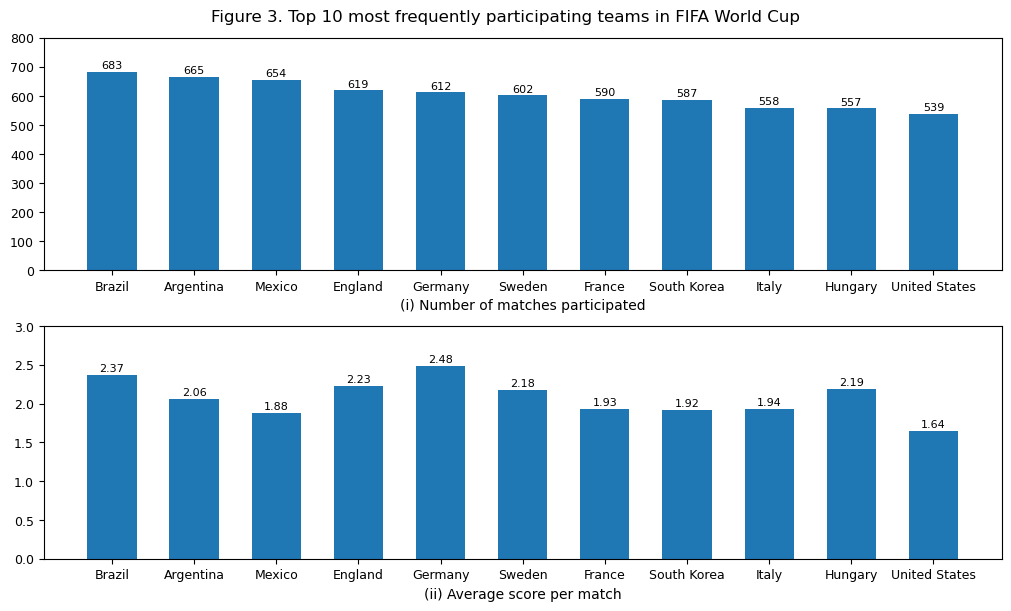

In [203]:
fig, axes = plt.subplots(nrows=2, layout="constrained", figsize=(10,6))

rect1 = axes[0].bar(x=df_vis3.loc[:10,"team"], height=df_vis3.loc[:10,"num_matches"], width=0.6)
axes[0].bar_label(rect1, padding=1, size=8)
axes[0].tick_params(axis="both", labelsize=9)
axes[0].set_yticks(np.arange(0,850,100))
axes[0].set_xlabel("(i) Number of matches participated")

rect2 = axes[1].bar(x=df_vis3.loc[:10,"team"], height=df_vis3.loc[:10,"avg_score_per_match"], width=0.6)
axes[1].bar_label(rect2, padding=1, size=8, fmt="%.2f")
axes[1].tick_params(axis="both", labelsize=9)
axes[1].set_yticks(np.arange(0,3.5,0.5))
axes[1].set_xlabel("(ii) Average score per match")

plt.suptitle("Figure 3. Top 10 most frequently participating teams in FIFA World Cup")
plt.show()

### 5. Historical trends in FIFA participations across the past decades

We can also look into the trends in FIFA participations by decades and see how the international football scene we know as FIFA World Cup has grown overtime. To do this, we need to combine the home and away team again like the previous query, however we 
will use an alternative method in this query to achieve the same output. Instead of using `UNION` on separate home and away tables, we will aggregate the teams into arrays and concatenate them. Then we will use the `EXPLODE` function to unnest the array into rows for each array element. *Note: in other SQL language, such as PostgreSQL, we may use `UNNEST` instead and sometimes together with `CROSS JOIN`.*

We can round the year extracted into the lowest 10 and call it decade, i.e. if the year of the tournament is 1987, it will be rounded to 1980 as decade. This can be done by subtracting 5 from the year before rounding them off to multiple of 10 using `ROUND()` function.

To see the growth from decade to decade, we use the `LAG()` window function on the number of participating teams to get the previous numbers. We subtract that decade number of participating teams by the previous decade to see how much the FIFA football scene has grown over the decade.

As we can see, FIFA World Cup started with 38 participating countries, and has since grown to 206 countries in the 2010s. In 1940s, we can see a drop in FIFA participation likely due to the 
World War occurring in that period, leading to cancelled tournaments. 

In [207]:
query = """
WITH
    fifa_matches AS (
        SELECT EXTRACT(YEAR FROM date) AS year
            , ARRAY_AGG(away_team) || ARRAY_AGG(home_team) AS teams
        FROM matches
        WHERE tournament ILIKE '%fifa%'
        AND NOT tournament ILIKE '%anniversary%'
        GROUP BY 1
    ),
    fifa_teams AS (
        SELECT DISTINCT ROUND(year -5, -1) AS decade
            , EXPLODE (teams) AS teams
        FROM fifa_matches
    ),
    fifa_growth AS (
        SELECT *
            , LAG(num_teams, 1) OVER (ORDER BY decade) AS prev_num_teams
        FROM (
            SELECT decade
                , COUNT(*) AS num_teams
            FROM fifa_teams
            GROUP BY 1
            ORDER BY 1 ASC
        ) AS t
    )

SELECT *
    , ROUND(1.0 * (num_teams - prev_num_teams) / prev_num_teams, 2) AS growth_factor
FROM fifa_growth;
"""

df_vis4 = run(query)
df_vis4

,decade,num_teams,prev_num_teams,growth_factor
0,1930,38,NaN,None
1,1940,17,38.0,-0.55
2,1950,54,17.0,2.18
3,1960,73,54.0,0.35
4,1970,95,73.0,0.30
5,1980,114,95.0,0.20
6,1990,178,114.0,0.56
7,2000,207,178.0,0.16
8,2010,206,207.0,0.00
9,2020,185,206.0,-0.10


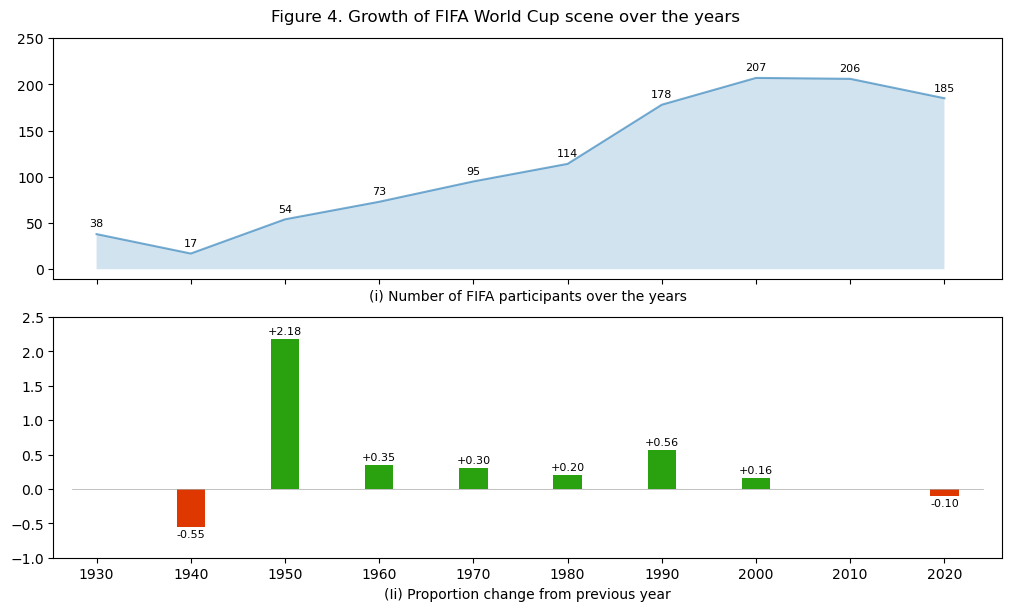

In [256]:
fig, axes = plt.subplots(nrows=2, layout="constrained", sharex=True, figsize=(10,6))

axes[0].fill_between(x=df_vis4['decade'], y1=df_vis4["num_teams"], alpha=0.2)
axes[0].plot(df_vis4['decade'], df_vis4["num_teams"], alpha=0.6)

for year, num in df_vis4[["decade","num_teams"]].values:
    axes[0].annotate(num, (year, num + 8), ha="center", size=8)
    
axes[0].set_yticks(np.arange(0,300,50))
axes[0].set_xlabel("(i) Number of FIFA participants over the years")

positive = df_vis4['growth_factor'] > 0
negative = df_vis4['growth_factor'] < 0

rect1 = axes[1].bar(x=df_vis4[positive]['decade'], height=df_vis4[positive]['growth_factor'], width=3, color="#2AA10F")
rect2 = axes[1].bar(x=df_vis4[negative]['decade'], height=df_vis4[negative]['growth_factor'], width=3, color="#DE3700")
axes[1].axhline(y=0, xmin=0.02, xmax=0.98, lw=0.5, color="darkgrey")

axes[1].bar_label(rect1, padding=2, size=8, fmt="+%.2f")
axes[1].bar_label(rect2, padding=2, size=8, fmt="%.2f")
axes[1].set_yticks(np.arange(-1,3,0.5))
axes[1].set_xticks(np.arange(1930, 2030, 10))
axes[1].set_xlabel("(Ii) Proportion change from previous year")

fig.suptitle("Figure 4. Growth of FIFA World Cup scene over the years")
plt.show()

## VI. Conclusion

From this notebook, we have displayed how we can use SparkSQL to perform queries and data explorations. Although the dataset used in our case was small, SparkSQL is definitely a useful tool in working with big data, connecting our expertise in SQL with pandas capabilities. 

Ultimately, we have answered the key questions that we are looking for using SparkSQL:

* **How many FIFA matches have been held so far?**
  * 7.7k qualifier matches beginning 1933
  * 948 world cup matches beginning 1930, no qualifier matches when FIFA first started
  
* **Which teams qualified, hence participated the most in FIFA?**
  * Brazil, Argentina and Mexico are the top 3 most frequently participating teams
  * With average scores per match 2.37, 2.06 and 1.88 respectively
  
* **Which teams are the top performing teams?**
  * In terms of winning matches, Brazil, Germany and Argentina are the top 3 highest performers
  * With total wins of 155, 150 and 129 respectively
  * With average goal difference of 2.45, 2.67 and 1.98 respectively
  
* **How has international football scene develop over the years?**
  * Started of in 1930s with only 38 participating teams
  * Progress was halted in 1940s due to the World War
  * Has quickly grown to 185 participating countries by 2020

***
<p style="text-align:center;"><b>EOF</b><p>